In [14]:
# CELL 1 – Imports
import os
import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import joblib
import nltk
from nltk.tokenize import sent_tokenize

nltk.download("punkt")
nltk.download("stopwords")


print("All imports successful!")


All imports successful!


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# CELL 2 – Create training dataset for summarization
data = [
    {
        "input_text": (
            "Machine learning is a field of artificial intelligence that "
            "focuses on building systems that learn from data. These systems "
            "can improve their performance on tasks over time without being "
            "explicitly programmed for every rule."
        ),
        "target_summary": (
            "Machine learning is AI where systems learn from data and improve "
            "performance over time."
        ),
    },
    {
        "input_text": (
            "Python is a high-level, interpreted programming language known "
            "for its readability and large ecosystem of libraries. It is "
            "widely used in web development, data science, automation, and "
            "machine learning."
        ),
        "target_summary": (
            "Python is a readable, high-level language used in web, data "
            "science, automation, and ML."
        ),
    },
    {
        "input_text": (
            "Supervised learning uses labeled data to train models, meaning "
            "each input comes with the correct output. The model learns to "
            "map inputs to outputs so it can make predictions on new, "
            "unseen data."
        ),
        "target_summary": (
            "Supervised learning trains models on labeled data so they can "
            "predict outputs for new inputs."
        ),
    },
    {
        "input_text": (
            "Neural networks are computational models inspired by the human "
            "brain. They consist of layers of interconnected nodes that can "
            "learn complex patterns from data through training."
        ),
        "target_summary": (
            "Neural networks are layered models that learn complex patterns "
            "from data, inspired by the brain."
        ),
    },
    {
        "input_text": (
            "Deep learning is a subset of machine learning using neural networks "
            "with multiple layers to learn representations of data. It has "
            "achieved remarkable success in image recognition, natural language "
            "processing, and other complex tasks."
        ),
        "target_summary": (
            "Deep learning uses multi-layer neural networks to learn data "
            "representations, succeeding in vision and NLP tasks."
        ),
    },
]

df = pd.DataFrame(data)
print(f"Created training dataset with {len(df)} samples")
df.head()


Created training dataset with 5 samples


,input_text,target_summary
0,Machine learning is a field of artificial inte...,Machine learning is AI where systems learn fro...
1,"Python is a high-level, interpreted programmin...","Python is a readable, high-level language used..."
2,Supervised learning uses labeled data to train...,Supervised learning trains models on labeled d...
3,Neural networks are computational models inspi...,Neural networks are layered models that learn ...
4,Deep learning is a subset of machine learning ...,Deep learning uses multi-layer neural networks...


In [6]:
# CELL 3 – Prepare tokenizers
input_texts = df["input_text"].tolist()
target_texts = df["target_summary"].tolist()

num_words = 5000
oov_token = "<OOV>"

input_tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
input_tokenizer.fit_on_texts(input_texts)

target_tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
target_tokenizer.fit_on_texts(target_texts)

input_sequences = input_tokenizer.texts_to_sequences(input_texts)
target_sequences = target_tokenizer.texts_to_sequences(target_texts)

max_input_len = max(len(seq) for seq in input_sequences)
max_target_len = max(len(seq) for seq in target_sequences)

print(f"Max input length: {max_input_len}")
print(f"Max target length: {max_target_len}")


Max input length: 34
Max target length: 17


In [7]:
# CELL 4 – Pad sequences
X = pad_sequences(input_sequences, maxlen=max_input_len, padding="post", truncating="post")
y = pad_sequences(target_sequences, maxlen=max_target_len, padding="post", truncating="post")

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")


X shape: (5, 34)
y shape: (5, 17)


In [8]:
# CELL 5 – Build Keras embedding + LSTM model
embedding_dim = 64
latent_dim = 128
vocab_size = num_words

inputs = keras.Input(shape=(max_input_len,))
x = layers.Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs)
x = layers.Bidirectional(layers.LSTM(latent_dim))(x)
x = layers.Dense(128, activation="relu")(x)
outputs = layers.Dense(vocab_size, activation="softmax")(x)

model = keras.Model(inputs, outputs)
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"],
)

print("Model summary:")
model.summary()


Model summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 34)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 34, 64)    │    320,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 34)        │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 256)       │    197,632 │ embedding[0][0],  │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     32,896 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 5000)      │    645,000 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,195,528 (4.56 MB)

 Trainable params: 1,195,528 (4.56 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# CELL 6 – Prepare targets (first token of each summary)
y_first_token = np.array([seq[0] if len(seq) > 0 else 0 for seq in target_sequences])
print(f"Target shape: {y_first_token.shape}")


Target shape: (5,)


In [10]:
# CELL 7 – Train Keras model
history = model.fit(
    X,
    y_first_token,
    epochs=50,
    batch_size=2,
    verbose=1,
)

print("\nModel training complete!")


Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.0000e+00 - loss: 8.5180
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6000 - loss: 8.5038
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6000 - loss: 8.4872
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4000 - loss: 8.4474    
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4000 - loss: 8.3361
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.2000 - loss: 7.7725
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2000 - loss: 5.9890    
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2000 - loss: 3.9364
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2000 - loss: 2.4566    
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2000 - loss: 2.0513
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.2000 - loss: 1.8713
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2000 

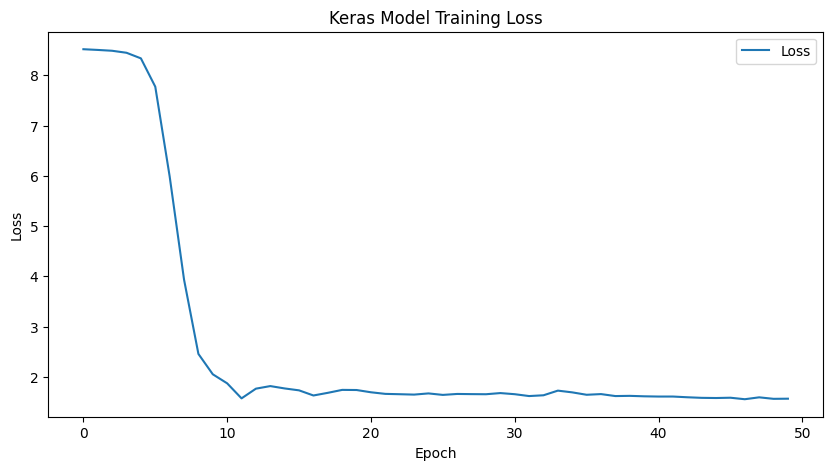

Training plot saved to data/summarizer_training.png


In [11]:
# CELL 8 – Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history.history["loss"], label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Keras Model Training Loss")
plt.legend()
plt.savefig("../data/summarizer_training.png")
plt.show()

print("Training plot saved to data/summarizer_training.png")


In [15]:
# CELL 9 – Define extractive summarizer function
def simple_extractive_summary(text: str, max_sentences: int = 2) -> str:
    """
    Simple extractive summarizer: returns first N sentences.
    """
    text = (text or "").strip()
    if not text:
        return ""

    sentences = sent_tokenize(text)

    if len(sentences) <= max_sentences:
        return text

    return " ".join(sentences[:max_sentences])

# Test it
test_text = df["input_text"].iloc[0]
print("Original text:")
print(test_text)
print("\n\nSummarized:")
print(simple_extractive_summary(test_text, max_sentences=2))


Original text:
Machine learning is a field of artificial intelligence that focuses on building systems that learn from data. These systems can improve their performance on tasks over time without being explicitly programmed for every rule.


Summarized:
Machine learning is a field of artificial intelligence that focuses on building systems that learn from data. These systems can improve their performance on tasks over time without being explicitly programmed for every rule.


In [ ]:
# CELL 10 – Save Keras model and tokenizers
models_dir = "../backend/models"
os.makedirs(models_dir, exist_ok=True)

model_path = os.path.join(models_dir, "summarizer_keras_model.h5")
input_tok_path = os.path.join(models_dir, "summarizer_input_tokenizer.joblib")
target_tok_path = os.path.join(models_dir, "summarizer_target_tokenizer.joblib")

model.save(model_path)
joblib.dump(input_tokenizer, input_tok_path)
joblib.dump(target_tokenizer, target_tok_path)

print(f"Keras model saved to: {model_path}")
print(f"Input tokenizer saved to: {input_tok_path}")
print(f"Target tokenizer saved to: {target_tok_path}")
